C:\Users\Satish\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


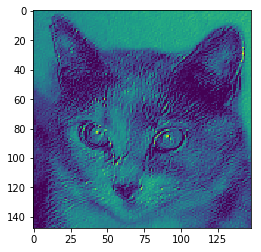

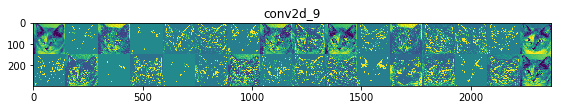

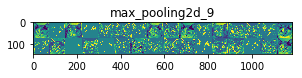

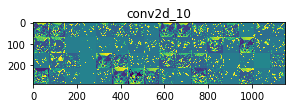

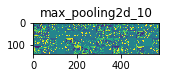

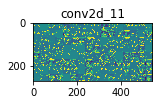

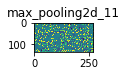

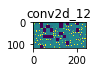

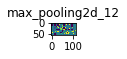

In [2]:
#################### 5.25 Preprocessing a single image #################################################

from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models

model = load_model('cats_and_dogs_small_2.h5')
# model.summary()

image_path = '/Users/Satish/python_files/cats_and_dogs_small/test/cats/cat.1700.jpg'

img = image.load_img(image_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# print(img_tensor.shape)

############## Displaying the test picture
# plt.imshow(img_tensor[0])
# plt.show()

############### Instantiating a model from an input tensor and a list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]] ## Extracts the outputs of the top eight layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)#Creates a model that will return these outputs


############### Running the model in predict mode
activation = activation_model.predict(img_tensor) # Returns a list of five Numpy arrays, one array per layer activation


############### first convolution layer for the cat image input
first_layer_activation = activation[0]
# print(first_layer_activation.shape)

############### Visualizing the fourth channel
plt.imshow(first_layer_activation[0, :, :, 4], cmap='viridis')

############### Visualizing the seventh channel
plt.imshow(first_layer_activation[0, :, :, 7], cmap='viridis')

#################### 5.31 Visualizing every channel in every intermediate activation##########################

layer_names = []  ### Names of the layers
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_show = 16

for layer_name, layer_activation in zip (layer_names, activation):
    n_features = layer_activation.shape[-1] ## Number of features in the feature map
    size = layer_activation.shape[1] ## The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_show ## Tiles the activation channels in this matrix
#     print('size:', size, "n_cols:", n_cols, 'image_per_show:', images_per_show)
    display_grid = np.zeros((size * n_cols, images_per_show * size))
    for col in range(n_cols): ## Tiles each filter into a big horizontal grid
        for row in range(images_per_show):
            channel_image = layer_activation[0, :, :, col * images_per_show + row]
            channel_image -= channel_image.mean() ##  Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image
    scale = 1./255
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


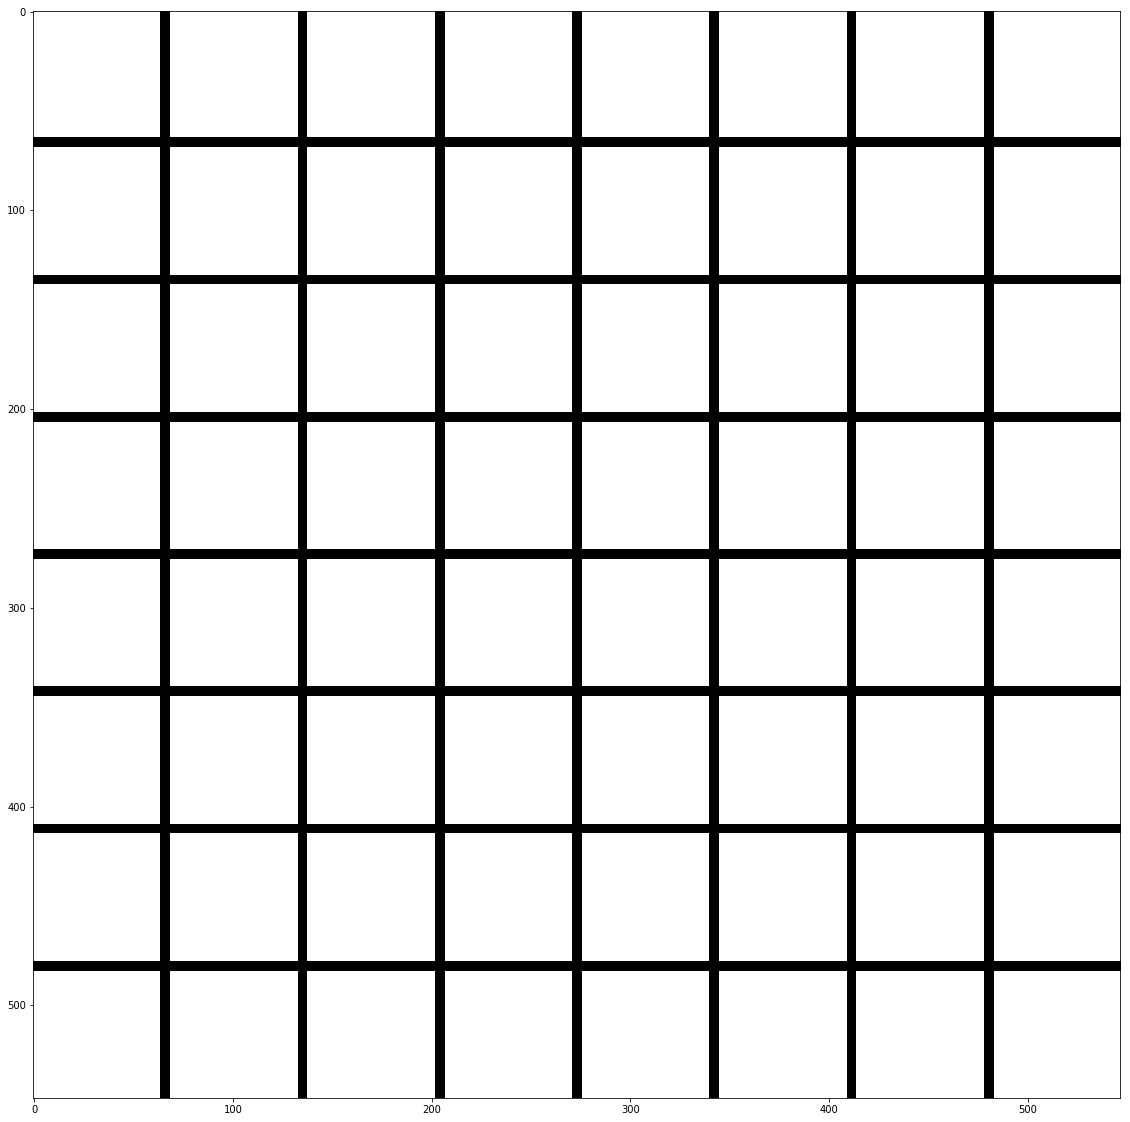

In [3]:
#################### 5.32 Defining the loss tensor for filter visualization ##########################

from keras.applications import VGG16
from keras import backend as K
import numpy as np

model = VGG16(weights = 'imagenet', include_top = False)
layer_name = 'block3_conv1'
filter_index = 0
layar_output = model.get_layer(layer_name).output
loss = K.mean(layar_output[:, :, :, filter_index])


#################### 5.33 Obtaining the gradient of the loss with regard to the input ###################

grads = K.gradients(loss, model.input)[0] ## The call to gradients returns a list of tensors
                                          ## Hence, you keep only the first element which is a tensor.  

#################### 5.34 Gradient-normalization ######################################################

## In Order to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by 
## its L2 norm (the square root of the average of the square of the values in the tensor)

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) ## Add 1e–5 before dividing to avoid accidentally dividing by 0 

################## 5.35 Fetching Numpy output values given Numpy input values ###########################

## to compute the value of the loss tensor and the gradient tensor, given an input image we can define a Keras 
## backend function using Iterate which takes a Numpy tensor 
## returns a list of two Numpy tensors the loss value and the gradient value

iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

################## 5.36 Loss maximization via stochastic gradient descent ###########################

input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128 ## Starts from a gray image with some noise
step = 1 ## Magnitude of each gradient update
for i in range(40): ## Runs gradient ascent for 40 steps
    loss_value, grads_value = iterate([input_img_data]) ## Computes the loss value and gradient value
    input_img_data += grads_value * step

################## 5.37 Utility function to convert a tensor into a valid image ###########################    

## The resulting image tensor is a floating-point tensor of shape (1, 150, 150, 3), with values that may not be integers
## within [0, 255], that's y need to postprocess this tensor to turn it into a displayable image

def deprocess_image(x): ## Normalizes the tensor: centers on 0, ensures that std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1) ## Clips to [0, 1]     
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8') ## Converts to an RGB array
    return x
    
################## 5.38 Function to generate filter visualizations #######################################

## Let’s put together all the pieces into a Python function that takes as input a layer name and a filter index
## returns a valid image tensor representing the pattern that maximizes the activation of the specified filter

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index]) ## Builds a loss function that maximizes the activation of 
                                                       ## the nth filter of the layer
    
    grads = K.gradients(loss, model.input)[0] ## Computes the gradient of the input picture with regard to this loss
    grads /= (K.sqrt(K.mean(K.sqrt(grads))) + 1e-5) ## normalizes the gradient
    iterate = K.function([model.input], [loss, grads]) ## Returns the loss and grads given the input picture
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128 ## Starts from a gray image with some noise
    step = 1
    for i in range(40): ### Runs gradient ascent for 40 steps
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img  = input_img_data[0]
    return deprocess_image(img)

# plt.imshow(generate_pattern('block3_conv1', 0))
    
## It seems that filter 0 in layer is responsive to a polka-dot pattern block3_conv1


################## 5.39 Generating a grid of all filter response patterns in a layer #############################

## Now, we can start visualizing every filter in every layer, i. e. look at the first 64 filters in each layer and
## look at the first layer of each convolution block(block1_conv1,lock2_conv1,block3_conv1,block4_ conv1,block5_conv1)

layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3)) ## Empty (black) image to store results

for i in range(8):     ## Iterates over the rows of the results grid
    for j in range(8): ## Iterates over the columns of the results grid
        filter_img = generate_pattern(layer_name, i + (j * 8), size = size) ## Generates the pattern for 
                                                                            ## filter i + (j * 8) in layer_name
        ### Puts the result in the square (i, j) of the results grid    
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results) ## Displays the results grid


True

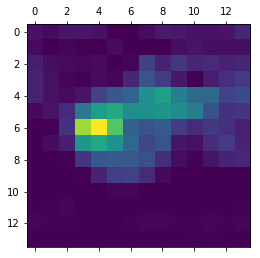

In [5]:
########################### Visualizing heatmaps of class activation #################################################

################## 5.40 Loading the VGG16 network with pretrained weights #############################

from keras.applications.vgg16 import VGG16

model = VGG16(weights = 'imagenet') ## discarded the densely connected classifier on top

### Consider the image of two African elephants, let’s convert this image into something the VGG16 model can read 
### the model was trained on images of size 224 × 244, preprocessed according to rules that are packaged in
### the utility function.
### need to load the image, resize it to 224 × 224, convert it to a Numpy float32 tensor, and apply preprocessing rules

################## 5.41 Preprocessing an input image for VGG16 ############################################

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import numpy as np

img_path = '/Users/Satish/python_files/creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224)) ## Python Imaging Library (PIL) image of size 224 × 224
x = image.img_to_array(img) ## float32 Numpy array of shape (224, 224, 3)
x = np.expand_dims(x, axis=0) ## Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = preprocess_input(x) ## Preprocesses the batch (this does channel-wise color normalization)

# x /= 255.
# plt.imshow(x[0])
# plt.show()

# now run the pretrained network on the image and decode its prediction vector back to a human-readable format
preds = model.predict(x)
# print('Predicted:', decode_predictions(preds, top=3)[0])

## The entry in the prediction vector, was maximally activated is the one corresponding to the “African elephant” class,
## at index 386

np.argmax(preds[0])

################## 5.42 Setting up the Grad-CAM algorithm ########################################

### To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process.

african_elephant_output = model.output[:, 386] ## “African elephant” entry in the prediction vector
last_conv_layer = model.get_layer('block5_conv3') ## Output feature map of the block5_conv3 layer,
                                                  ## the last convolutional layer in VGG16

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] ## Gradient of the “African elephant” class 
                                                            ## with regard to the output feature map of block5_conv3
    
pooled_grads = K.mean(grads, axis = (0, 1, 2)) ## Vector of shape (512,), where each entry is the mean intensity of 
                                               ## the gradient over a specific feature-map channel    
    
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) ## To access the values of the quantities
                        ## just defined, pooled_grads and the output feature map of block5_conv3, given a sample image   
    
pooled_grads_value, conv_layer_output_value = iterate([x]) ## Values of these two quantities, as Numpy arrays, 
                                                           ## given the sample image of two elephants

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1) ## The channel-wise mean of the resulting feature map
                                                      ## is the heatmap of the class activation    
    
################## 5.43 Heatmap post-processing #######################################################   

## For visualization purposes, normalize the heatmap between 0 and 1

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

################## 5.43 Heatmap post-processing #######################################################  

### Now, use OpenCV to generate an image that superimposes the original image on the heatmap

import cv2
img = cv2.imread(img_path) ### Uses cv2 to load the original image
heatmap = cv2.resize(heatmap,(img.shape[1], img.shape[0])) ## Resizes the heatmap as the original image shape
heatmap = np.uint8(255 * heatmap) ## Converts the heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) ## Applies the heatmap to the original image
superimposed_img = heatmap * 0.4 + img ## 0.4 here is a heatmap intensity factor 
cv2.imwrite('/Users/Satish/python_files/elephant_cam.jpg', superimposed_img) ## save the image on disk